# Web Scraping of Everywhereist.com using Scrapy #

## by Lorenz Madarang ##

## website http://www.everywhereist.com/blog/ ##

### Web Scraper ###
A Web Scraper was created using scrapy and it crawled the travel blog www.everywhereist.com.  It scraped through all the blog posts on the site and scraped the name of the blog post, the date of the blog post, and some initial lines of the blog post.  

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess


class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'http://www.everywhereist.com/blog/',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for article in response.xpath('//article'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code that extracts the name, date, and text of the blog post
                # You can modify this with other Xpath expressions to extract other information from the site
                'name': article.xpath('string(header/h2/a)').extract(), #works
                'date': article.xpath('string(header/div[@class="date"]/div[@class="actual-date"])').extract(), #works
                'text': article.xpath('div[@class="body"]/p/text()').extract(), #works
                
            }
            
        next_page = response.xpath('string(//div[@class="nav-links"]/a[@class="next page-numbers"]/@href)').extract_first()
        if next_page:
            yield scrapy.Request(
                  response.urljoin(next_page),
                  callback=self.parse
            )
# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'secondpage.json',  # Name our storage file.
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

### DataFrame ###
This is the resulting DataFrame from the Web Scraper.  It was able to scrape 1,410 blog posts for information.  Again, it was able to extract the name, the date, and a couple lines of the blog post. 

In [1]:
import pandas as pd

secondpage = pd.read_json('secondpage.json', orient='records')
print(secondpage.shape)
print(secondpage.head())

(1410, 3)
             date                                               name  \
0   [Sep 4, 2018]                      [I Quit Twitter for a Month.]   
1  [Jul 30, 2018]  [What Happened When I Tried Talking to Twitter...   
2  [Jul 19, 2018]                                [Lost And Founder.]   
3  [Jun 22, 2018]                          [Scenes From a Bookstore]   
4  [Jun 21, 2018]                   [782 Words About Writer’s Block]   

                                                text  
0  [I quit Twitter for a month. This should not s...  
1  [Trigger warning: please note that this is a b...  
2  [My beloved wrote a book. How it came to be wa...  
3  [“Why do they have so many copies of  my book?...  
4  [I don’t know what writer’s block looks like f...  


### Data Cleaning ###
One of the first steps of cleaning the data was converting the data into strings.  After scraping the information from the web, the information was converted to a single element list.  This single element list was not going to be helpful when conducting analysis so the data was converted to a string.  Then the date column was converted into a timestamp object.  Next weird characters were removed from the string.  Finally, the blog texts were separated into sentences.  

In [2]:
# Convert data into a string 

for index, row in secondpage.iterrows():
    row['date'] = ''.join(row['date'])
    row['name'] = ''.join(row['name'])
    row['text'] = ''.join(row['text'])

In [3]:
secondpage.loc[69, 'text']

'The thing that I did not anticipate when it came to publishing\xa0a book\xa0(which – wink, wink – is available for pre-order) is that my photo would appear somewhere on it. That seemed really strange, and also made me weirdly uncomfortable, which makes no sense. Like, that’s\xa0the point when I suddenly decided to become a private…'

In [4]:
# Convert date column to timestamp object

for index, row in secondpage.iterrows():
    row['date'] = pd.to_datetime(row['date'])

In [5]:
secondpage.loc[69, 'date']

Timestamp('2017-02-01 00:00:00')

In [6]:
# Remove weird characters

for index, row in secondpage.iterrows():
    row['text'] = row['text'].replace('\xa0', ' ')

In [7]:
# Split the text into sentences

for index, row in secondpage.iterrows():
    row['text'] = row['text'].split('.')

### Sentiment Analysis ###
Using NLTK, Sentiment Analysis was conducted on the blog posts.  Then the average compound sentiment analysis score was calculated for each blog post and it was put in the DataFrame.

In [8]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\lmadarang\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [9]:
test = secondpage.loc[69, 'text']

In [10]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lmadarang\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
# Sample Sentiment Analysis Scores from one post 

sid = SentimentIntensityAnalyzer()
for sentence in test:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

The thing that I did not anticipate when it came to publishing a book (which – wink, wink – is available for pre-order) is that my photo would appear somewhere on it
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
 That seemed really strange, and also made me weirdly uncomfortable, which makes no sense
compound: -0.796, neg: 0.476, neu: 0.524, pos: 0.0, 
 Like, that’s the point when I suddenly decided to become a private…
compound: 0.3612, neg: 0.0, neu: 0.783, pos: 0.217, 


In [12]:
import numpy as np

In [13]:
# Create a list of the mean compound sentiment analysis score for each blog post

list_scores = []
for index, row in secondpage.iterrows():
    mean_scores = []
    for sentence in row['text']:
        ss = sid.polarity_scores(sentence)
        mean_scores.append(ss['compound'])
    list_scores.append(np.mean(mean_scores))

In [14]:
# Add list to DataFrame column titled 'mean_scores'

secondpage['mean_scores'] = list_scores

In [15]:
secondpage.head()

,date,name,text,mean_scores
0,2018-09-04 00:00:00,I Quit Twitter for a Month.,"[I quit Twitter for a month, This should not ...",-0.259600
1,2018-07-30 00:00:00,What Happened When I Tried Talking to Twitter ...,[Trigger warning: please note that this is a b...,-0.395225
2,2018-07-19 00:00:00,Lost And Founder.,"[My beloved wrote a book, How it came to be w...",0.127650
3,2018-06-22 00:00:00,Scenes From a Bookstore,[“Why do they have so many copies of my book?...,0.004060
4,2018-06-21 00:00:00,782 Words About Writer’s Block,[I don’t know what writer’s block looks like f...,0.261775


### Data Visualizations ###
Three visualizations were created from the dataframe.  The first visualization is a time series plot where the average compound sentiment anlaysis was plotted over time.  Looking at the time series plot there seems to be cycles associated with the with the average compound sentiment analysis score.  It appears that they go up and down in a regular pattern.  The second visualization is a bar graph of the sentiment anlysis score by month.  It seems that the most positive month of the year for the author was September and the most negative month of the year was November.  The third visualization is a bar graph of the sentiment analysis score by year.  It seems that the most positive year for the author was 2017 and the most negative year for the author was 2016. 

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure

In [25]:
# Get current size

fig_size = plt.rcParams["figure.figsize"]

In [26]:
# Prints: [8.0, 6.0]

print ("Current size:{}".format(fig_size))

Current size:[15.0, 12.0]


In [27]:
# Set figure width to 12 and height to 9

fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [28]:
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

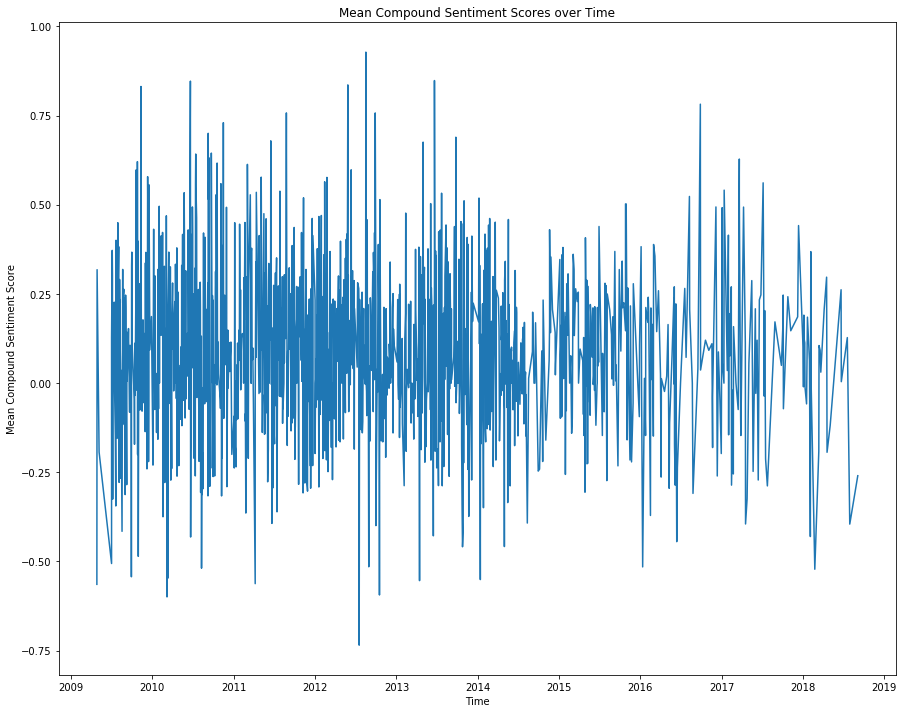

In [29]:
# First visualization - Time Series Plot of Mean Compound Sentient Score

x = secondpage['date']
y = secondpage['mean_scores']
plt.title('Mean Compound Sentiment Scores over Time')
plt.xlabel('Time')
plt.ylabel('Mean Compound Sentiment Score')
plt.plot(x,y)
plt.show()

In [77]:
#Create empty list that will hold the year, month, and hour values

year = []
month = []
day = []

#Iterate through Dataframe

for index, row in secondpage.iterrows():
    year.append(row['date'].year)
    month.append(row['date'].month)
    day.append(row['date'].day)
    
secondpage['year'] = year
secondpage['month'] = month
secondpage['day'] = day

In [78]:
secondpage.head()

,date,name,text,mean_scores,year,month,day
0,2018-09-04 00:00:00,I Quit Twitter for a Month.,"[I quit Twitter for a month, This should not ...",-0.259600,2018,9,4
1,2018-07-30 00:00:00,What Happened When I Tried Talking to Twitter ...,[Trigger warning: please note that this is a b...,-0.395225,2018,7,30
2,2018-07-19 00:00:00,Lost And Founder.,"[My beloved wrote a book, How it came to be w...",0.127650,2018,7,19
3,2018-06-22 00:00:00,Scenes From a Bookstore,[“Why do they have so many copies of my book?...,0.004060,2018,6,22
4,2018-06-21 00:00:00,782 Words About Writer’s Block,[I don’t know what writer’s block looks like f...,0.261775,2018,6,21


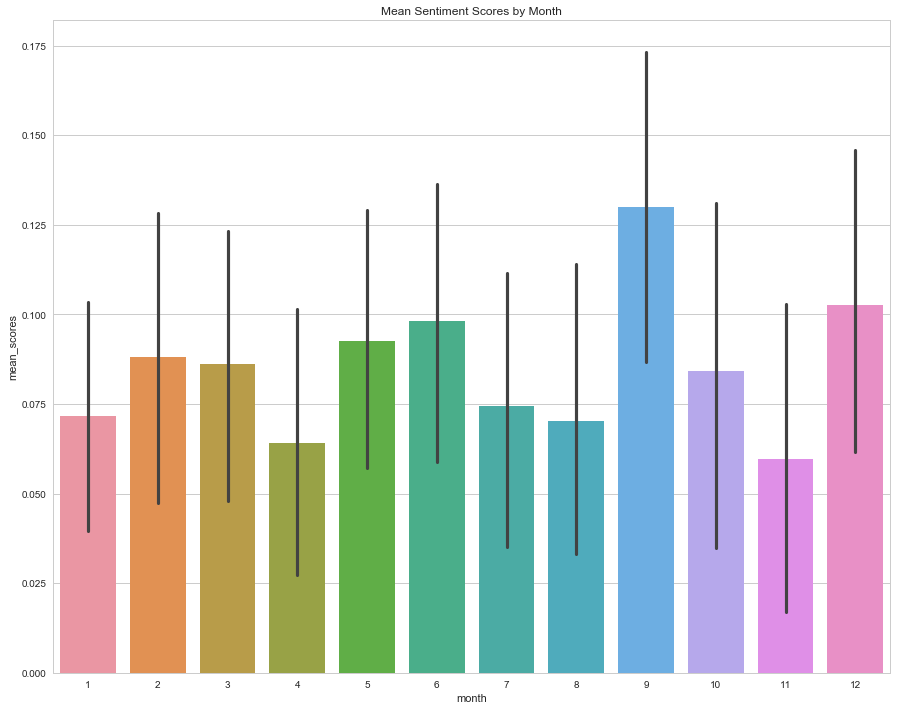

In [85]:
sns.set(style="whitegrid")
plt.title('Mean Sentiment Scores by Month')
ax = sns.barplot(x="month", y="mean_scores", data=secondpage)

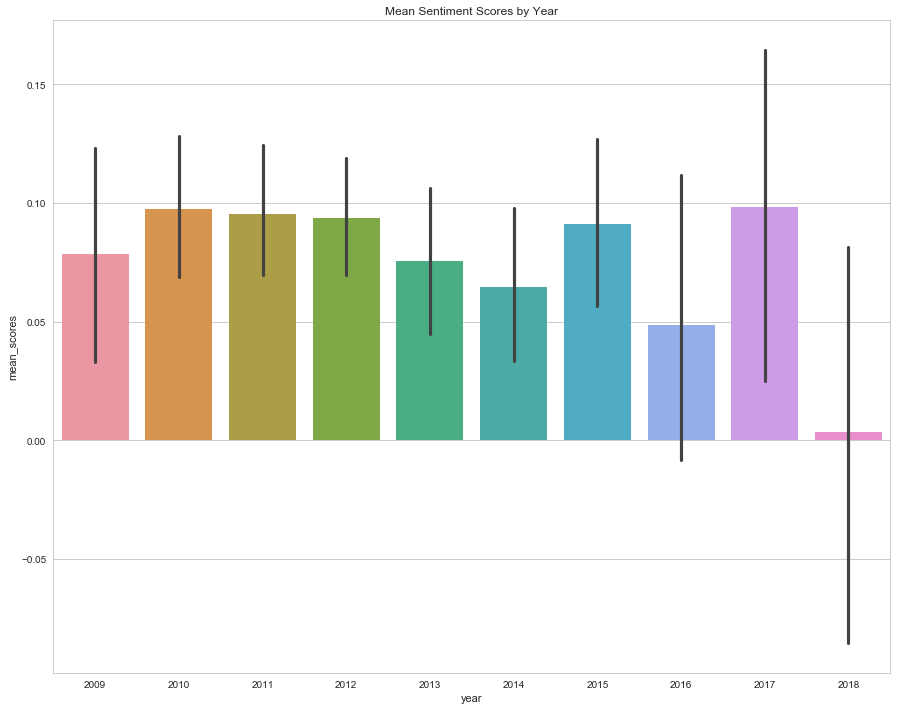

In [86]:
sns.set(style="whitegrid")
plt.title('Mean Sentiment Scores by Year')
ax = sns.barplot(x="year", y="mean_scores", data=secondpage)